In [6]:
from dotenv import load_dotenv
load_dotenv()
import os 
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")
groq_api_key = os.getenv("GROQ_API_KEY")
os.environ['TAVILY_API_KEY'] = os.getenv("TAVILY_API_KEY")
os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")
os.environ['LANGCHAIN_TRACKING_V2'] = "true"
os.environ['LANGCHAIN_PROJECT'] = "React-Agent"

In [7]:
## tools
from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

## tool wrapper
wiki_wrapper = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv_wrapper = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)

## Query runner
wiki = WikipediaQueryRun(api_wrapper=wiki_wrapper)
arxiv = ArxivQueryRun(api_wrapper=arxiv_wrapper)
tavily = TavilySearchResults()

In [8]:
## custom tools
def add(x:int, y:int)->int:
    """ add a and b
    args:
        a: first int
        b: second int
    
    """
    return x+y

def subtract(x:int, y:int)->int:
    """ subtract a and b
    args:
        a: first int
        b: second int
    
    """
    return x-y

def multiply(x:int, y:int)->int:
    """ multiply a and b
    args:
        a: first int
        b: second int
    
    """
    return x*y

def divide(x:int, y:int)->int:
    """ divide a and b
    args:
        a: first int
        b: second int
    
    """
    return x//y

In [9]:
tools = [wiki, arxiv, tavily, add, subtract, multiply, divide]

In [10]:
## llm
from langchain_groq import ChatGroq
llm = ChatGroq(model="openai/gpt-oss-120b", api_key=groq_api_key)
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x120cb7f50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x120a70b00>, model_name='openai/gpt-oss-120b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [11]:
# binding llm with the tools
llm = llm.bind_tools(tools)
llm

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x120cb7f50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x120a70b00>, model_name='openai/gpt-oss-120b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'wikipedia', 'description': 'A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'query to look up on wikipedia', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'arxiv', 'description': 'A wrapper around Arxiv.org Useful for when you need to answer questions about Physics, Mathematics, Computer Science, Quantitative Biology, Quantitative Finance, Statistics, Electrical Engineering, and Economics fro

In [12]:
from pydantic import BaseModel
from typing import Literal, Annotated
from langgraph.graph import add_messages
from langchain_core.messages import AnyMessage

class State(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]

In [14]:
def chat_model(state: State):
    return {"messages":llm.invoke(state.messages)}

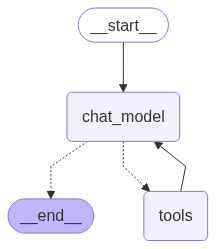

In [16]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import START, END, StateGraph

# defining state graph
builder = StateGraph(State)
## adding nodes
builder.add_node("chat_model", chat_model)
builder.add_node("tools", ToolNode(tools))

## adding edges to the node
builder.add_edge(START, "chat_model")
builder.add_conditional_edges("chat_model", tools_condition)
builder.add_edge("tools", "chat_model")

## compiling the builder to a graph
graph = builder.compile()

## display
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage
from pprint import pprint
messages = graph.invoke({"messages": HumanMessage(content="what is 2 plus 2 and divide by 2")})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

what is 2 plus 2 and divide by 2
================================== Ai Message ==================================

\( (2 + 2) \div 2 = \frac{4}{2} = 2 \).


In [20]:
from langchain_core.messages import HumanMessage
messages= graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (fc_15f7e5c0-c581-4e14-ac60-332b2fa99ebe)
 Call ID: fc_15f7e5c0-c581-4e14-ac60-332b2fa99ebe
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base
================================== Ai Message ==================================

**Paper

In [22]:
messages = graph.invoke({"messages": HumanMessage(content="who is goku, what is 2 plus 2,2 subtract 2, 2 multiply 2, 2 divide by 2, arxiv(1706.03762)")})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

who is goku, what is 2 plus 2,2 subtract 2, 2 multiply 2, 2 divide by 2, arxiv(1706.03762)
================================== Ai Message ==================================
Tool Calls:
  arxiv (fc_84bf95e8-bbff-47f3-be28-6f6691ae1066)
 Call ID: fc_84bf95e8-bbff-47f3-be28-6f6691ae1066
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base
=========

In [34]:
messages = graph.invoke({"messages": HumanMessage(content="what is tariff, what percentage of tariff does america put on india")})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

what is tariff, what percentage of tariff does america put on india
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fc_76e25d38-c194-4e2a-88a9-3e1048a2d024)
 Call ID: fc_76e25d38-c194-4e2a-88a9-3e1048a2d024
  Args:
    query: US tariff on Indian imports percentage average tariff United States India
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "After New Tariffs, Trust Between the United States and India Is ...", "url": "https://www.csis.org/analysis/after-new-tariffs-trust-between-united-states-and-india-running-low", "content": "*   Programs Hosted by Critical Minerals Security Program Hosted by International Security Program *   Critical Minerals Security Program *   Intelligence, National Security, and Technology Program *   International Security P

In [ ]:
messages['messages'][-1].content

'**What a tariff is**  \nA **tariff** is a tax or duty imposed by a government on goods that are imported (or, less commonly, exported) across its borders.  The purpose of a tariff can be to:\n\n* **Raise revenue** for the government.  \n* **Protect domestic industries** by making foreign goods more expensive relative to locally‑produced goods.  \n* **Retaliate** against another country’s trade policies (a “counter‑tariff”).  \n\nTariffs are usually expressed as a **percentage of the value of the imported product** (an ad‑valorem rate) or as a specific amount per unit (e.g.,\u202f$0.50 per kilogram).\n\n---\n\n## How much does the United States tariff on India?\n\n### 1.\u202fOverall U.S. applied‑tariff level (all partners)\n\n* **U.S. average applied tariff on all imports:** **≈\u202f3.3\u202f%** of the value of the goods.\u202fThis is the average “most‑favored‑nation” (MFN) duty that the United States applies to the world’s largest economies.\u202f【{"cursor": 2, "id": 0, "loc": 0}】  

# Memory Saver

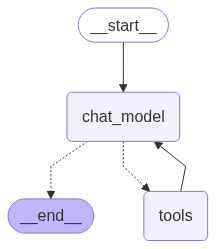

In [50]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import START, END, StateGraph

# defining state graph
builder = StateGraph(State)
## adding nodes
builder.add_node("chat_model", chat_model)
builder.add_node("tools", ToolNode(tools))

## adding edges to the node
builder.add_edge(START, "chat_model")
builder.add_conditional_edges("chat_model", tools_condition)
builder.add_edge("tools", "chat_model")


## adding memory safer function
from langgraph.checkpoint.memory import MemorySaver
graph_memory = MemorySaver()

## compiling the builder to a graph
graph = builder.compile(checkpointer=graph_memory)

## display
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [51]:
config = {"configurable":{"thread_id":"1"}}
messages = graph.invoke({"messages": HumanMessage(content="what is the current tarrif on india by us")}, config=config)

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

what is the current tarrif on india by us
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fc_bea9678f-e861-4ae1-b4b2-0aa486e4f1de)
 Call ID: fc_bea9678f-e861-4ae1-b4b2-0aa486e4f1de
  Args:
    query: current US tariff on India imports
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Trump tariffs: India has 20 days to avoid 50% levies", "url": "https://www.bbc.com/news/articles/c1w83j35jjjo", "content": "On Wednesday, Donald Trump doubled US tariffs on India to 50%, up from 25%, penalising Delhi for purchasing Russian oil - a move India called \"unfair\" and \"unjustified\". The tariffs aim to cut Russia's oil revenues and force Putin into a ceasefire. The new rate will come into effect in 21 days, so on 27 August.\n\nThis makes India the most heavily tax